In [ ]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install -q numpy==1.20.0
!pip install -q cellpose 
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
from tqdm.auto import tqdm
import tifffile
import matplotlib.pyplot as plt
import random

## Visualising Flows
#### 5-fold data Generated in cellpose format here: https://www.kaggle.com/ks2019/sartorius-train-tif

In [2]:
HOME = os.path.join('/home/ubuntu/kaggle-sartorius/')
RAW_DATA = os.path.join(HOME,'data/raw')
INTERIM_DATA = os.path.join(HOME,'data/interim')
PROCESSED_DATA = os.path.join(HOME,'data/processed')

TRAIN_CSV  = os.path.join(RAW_DATA,'train.csv')  
TRAIN_PATH = os.path.join(RAW_DATA,'train')  
TEST_PATH  = os.path.join(RAW_DATA,'test')  
MODELS_PATH = os.path.join(HOME,'models')
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = MODELS_PATH

In [3]:
FOLD = 0

c1f3e3b31108_img.tif


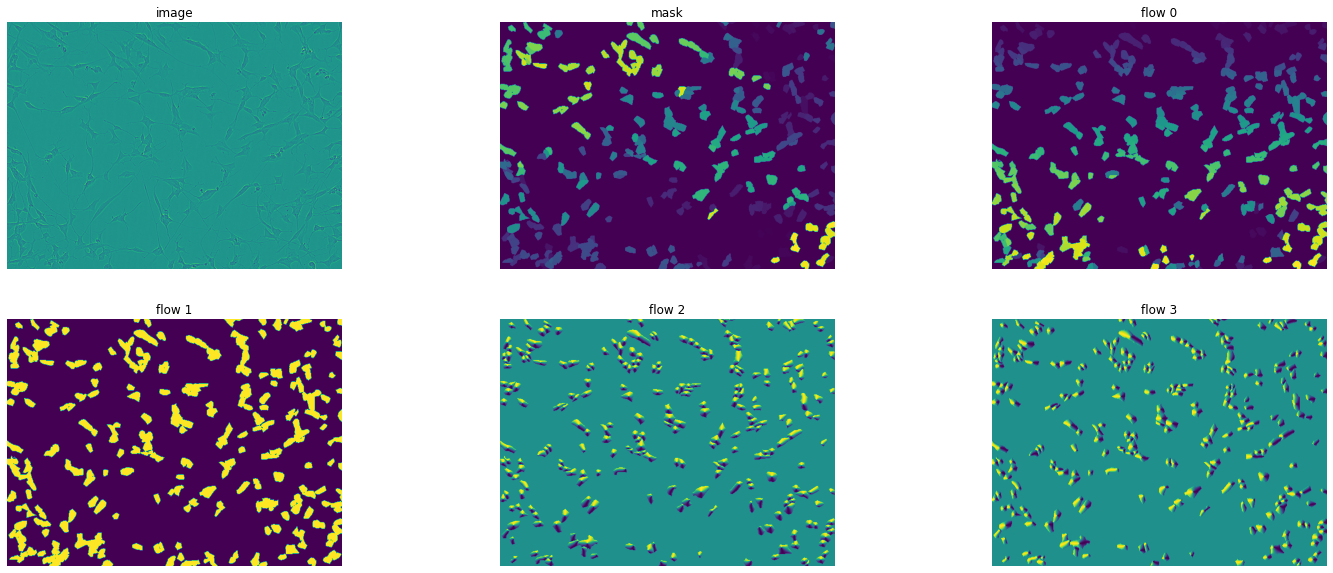

58b543a236c8_img.tif


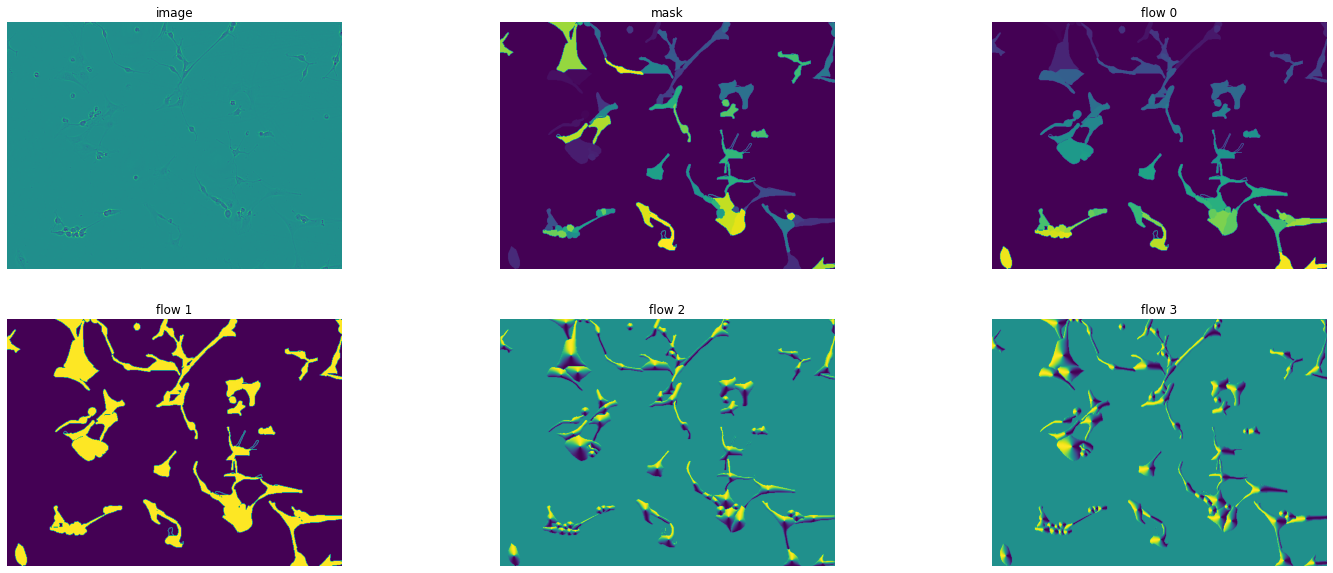

5c252798d269_img.tif


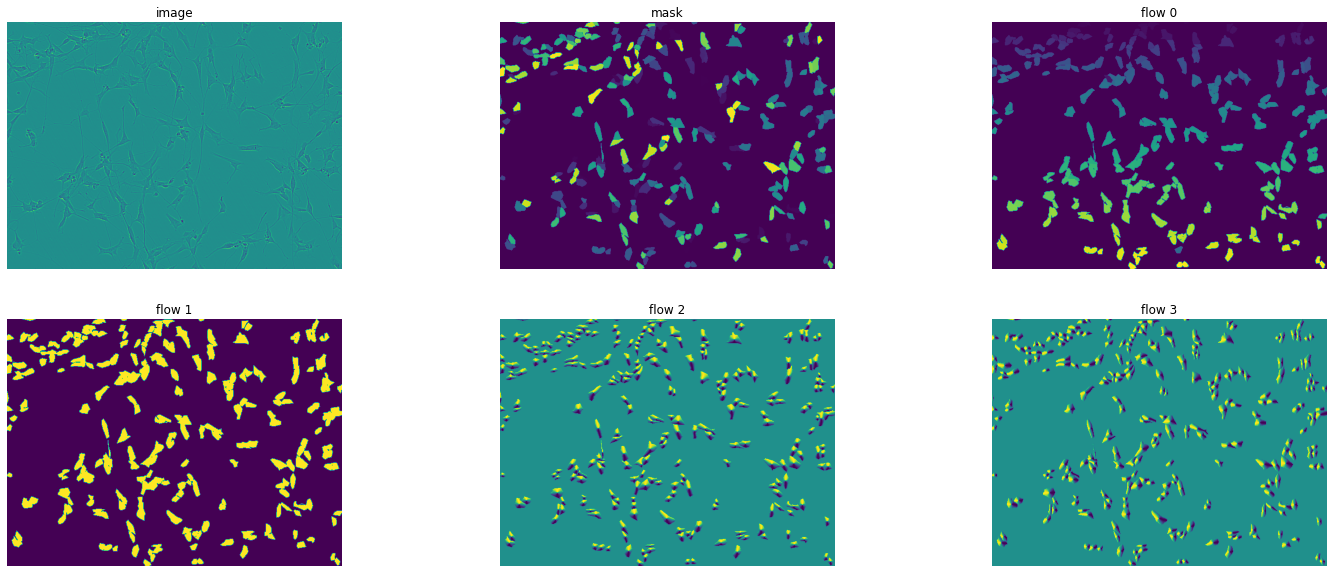

d8fc6dd956f8_img.tif


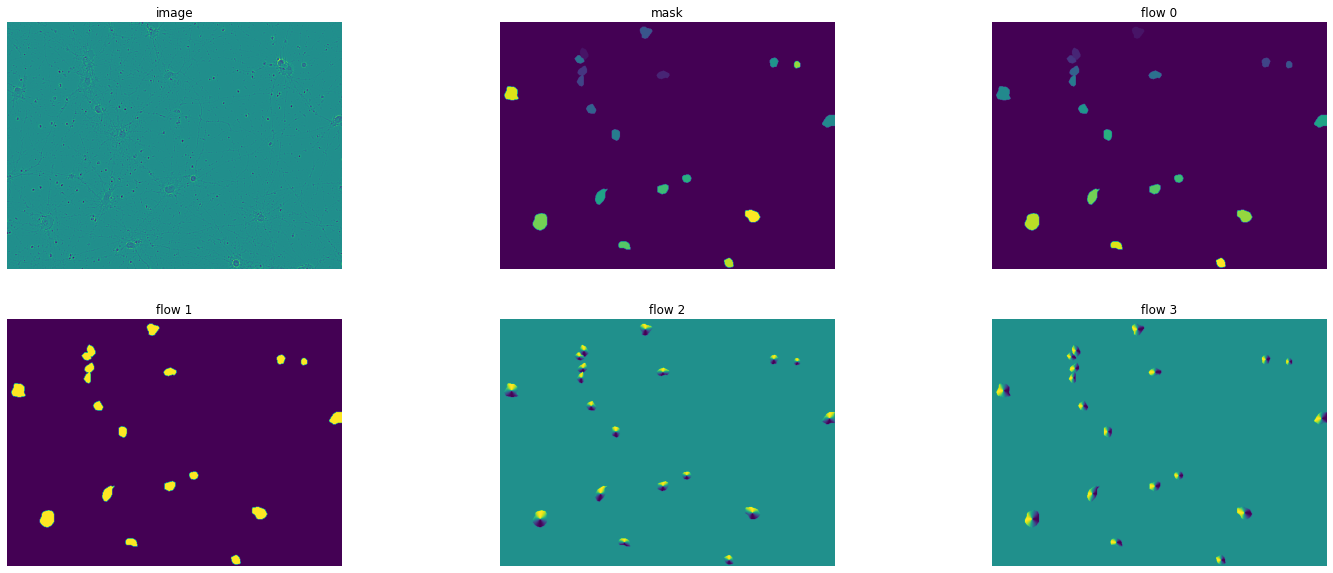

a55cec7ee7a1_img.tif


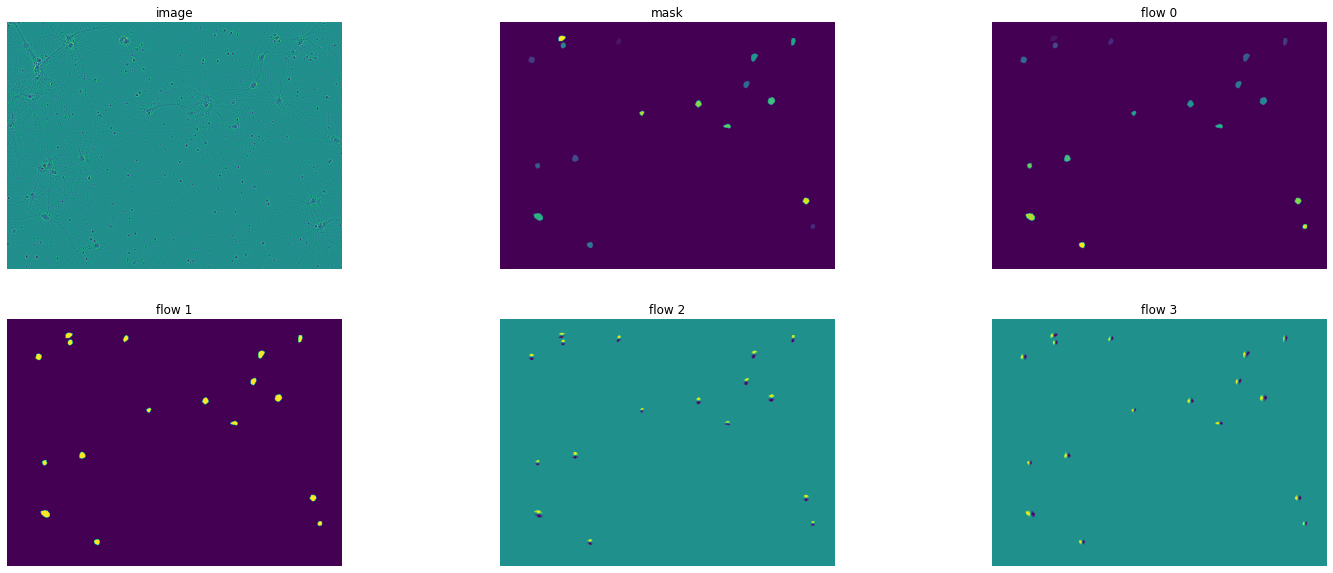

In [4]:
def plot_example(img_path):
    mask_path = img_path.replace('img','masks')
    flow_path = img_path.replace('img','flows')
    img = tifffile.imread(img_path)
    masks = tifffile.imread(mask_path)
    flows = tifffile.imread(flow_path)

    plt.figure(figsize=(25,10))
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.imshow(masks)
    plt.title('mask')
    for k in range(4):
        plt.subplot(2,3,3+k)
        plt.axis('off')
        plt.imshow(flows[k])
        plt.title(f'flow {k}')
    plt.show()
    
root = os.path.join(RAW_DATA,'sartorius-train-tif',f'fold_{FOLD}','train/') 
sample_paths = os.listdir(root)
sample_paths = [x for x in sample_paths if 'img' in x]
random.shuffle(sample_paths)
for k in range(5):
    img_path = sample_paths[k]
    print(img_path)
    plot_example(root+img_path)

## Train

In [5]:
model_to_load = 'cyto' ## cyto, cyto2, nuclei
number_of_epochs = 500  ## Train more epochs for better results
batch_size = 4
initial_learning_rate = 0.0001
Training_channel = 0 # For grayscale
Second_training_channel= 0 
train_folder = f'/tmp/cellpose_train/train'
test_folder = f'/tmp/cellpose_train/val'

In [6]:
!rm -rf /tmp/cellpose_train/

In [7]:
!mkdir -p /tmp/cellpose_train/

root = os.path.join(RAW_DATA,'sartorius-train-tif')
!cp -r {root}/fold_{FOLD}/* /tmp/cellpose_train/

In [8]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

1455
363


In [9]:
!cp -r {test_folder}/* {train_folder}

In [10]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

1818
363


In [17]:
model_to_load = '/home/ubuntu/kaggle-sartorius/notebooks/models/fold_0/models/diameter_40_part1'

In [11]:
from cellpose import models, io

2021-12-30 15:37:22,917 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log


In [12]:
cp_model=models.CellposeModel(
    gpu=True,
    pretrained_model=model_to_load,
    model_type=None,
    net_avg=True,
    torch=True,
    diam_mean=40.0,
    device=None,
    residual_on=True,
    style_on=True,
    concatenation=False,
    nchan=2,
    nclasses=3,
    omni=False,
)

2021-12-30 15:37:30,405 [WARNING] pretrained model has incorrect path
2021-12-30 15:37:30,408 [INFO] >>cyto<< model set to be used
2021-12-30 15:37:31,744 [INFO] ** TORCH CUDA version installed and working. **
2021-12-30 15:37:31,746 [INFO] >>>> using GPU


In [13]:
len(os.listdir(f'/tmp/cellpose_train/train/'))/3

606.0

In [14]:
train_data = []
train_labels = []
train_files = []
train_img_files = glob.glob(f'/tmp/cellpose_train/train/*_img.tif')
train_img_files = sorted(train_img_files)
train_mask_files = glob.glob(f'/tmp/cellpose_train/train/*_masks.tif')
train_mask_files = sorted(train_mask_files)
for fn in tqdm(train_img_files):
    train_data.append(io.imread(fn))
for fn in tqdm(train_mask_files):
    train_labels.append(io.imread(fn))

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

In [15]:
test_data = []
test_labels = []
test_files = []
test_img_files = glob.glob(f'/tmp/cellpose_train/val/*_img.tif')
test_img_files = sorted(test_img_files)
test_mask_files = glob.glob(f'/tmp/cellpose_train/val/*_masks.tif')
test_mask_files = sorted(test_mask_files)
for fn in tqdm(test_img_files):
    test_data.append(io.imread(fn))
for fn in tqdm(test_mask_files):
    test_labels.append(io.imread(fn))

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [18]:
cp_model.train(
    train_data=train_data,
    train_labels=train_labels,
    train_files=train_img_files,
    test_data=test_data,
    test_labels=test_labels,
    test_files=test_img_files,
    channels=[0,0],
    normalize=True,
    pretrained_model=model_to_load,
    save_path=f'./models/fold_{FOLD}/',
    save_every=20,
    save_each=False,
    learning_rate=0.0003,
    n_epochs=500,
    momentum=0.9,
    SGD=True,
    weight_decay=1e-05,
    batch_size=4,
    rescale=True,
    omni=False,
)

2021-12-30 15:57:42,462 [INFO] Training with rescale = 1.00
2021-12-30 15:57:50,969 [INFO] train channels = 2
2021-12-30 15:57:52,678 [INFO] test channels = 2
2021-12-30 15:57:52,679 [INFO] NOTE: computing flows for labels (could be done before to save time)


100%|██████████| 606/606 [01:16<00:00,  7.94it/s]


2021-12-30 15:59:14,519 [INFO] NOTE: computing flows for labels (could be done before to save time)


100%|██████████| 121/121 [01:10<00:00,  1.72it/s]


2021-12-30 16:00:28,360 [INFO] >>>> median diameter set to = 40
2021-12-30 16:00:28,362 [INFO] >>>> training network with 2 channel input <<<<
2021-12-30 16:00:28,362 [INFO] >>>> saving every 20 epochs
2021-12-30 16:00:28,363 [INFO] >>>> LR: 0.00030, batch_size: 4, weight_decay: 0.00001
2021-12-30 16:00:28,364 [INFO] >>>> ntrain = 606
2021-12-30 16:00:28,365 [INFO] >>>> rescale is 1
2021-12-30 16:00:28,365 [INFO] >>>> ntest = 121
2021-12-30 16:00:28,366 [INFO] (2, 520, 704)
2021-12-30 16:00:40,682 [INFO] Epoch 0, Time 12.3s, Loss 0.4733, Loss Test 0.4439, LR 0.0003
2021-12-30 16:00:53,196 [INFO] Epoch 1, Time 24.8s, Loss 0.4874, Loss Test 0.4426, LR 0.0003
2021-12-30 16:00:53,198 [INFO] saving network parameters to ./models/fold_0/models/cellpose_residual_on_style_on_concatenation_off__2021_12_30_16_00_25.528131
2021-12-30 16:01:05,924 [INFO] Epoch 2, Time 37.6s, Loss 0.4769, Loss Test 0.4431, LR 0.0003
2021-12-30 16:01:18,246 [INFO] Epoch 3, Time 49.9s, Loss 0.5179, Loss Test 0.4431, 

KeyboardInterrupt: 

In [ ]:
!python -m cellpose \
            --train \
            --use_gpu \
            --fast_mode \
            --diameter 17 \
            --dir "$train_folder" --test_dir "$test_folder" \
            --pretrained_model $model_to_load \
            --chan $Training_channel --chan2 $Second_training_channel \
            --n_epochs $number_of_epochs \
            --learning_rate 0.0001 \
            --batch_size 4 \
            --save_every 20 \
            --img_filter img \
            --mask_filter masks

In [ ]:
!ls -lh /tmp/cellpose_train/train/models

In [ ]:
!cp -r /tmp/cellpose_train/train/models/* ./models/fold_{FOLD}/

## Inference 

Refer: https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb

In [ ]:
glob.glob(f'models/fold_{FOLD}/*')[0]

In [19]:
##----------Update this Manually
model_path = '/home/ubuntu/kaggle-sartorius/notebooks/models/fold_0/models/diameter_40_part2'


print(model_path)

/home/ubuntu/kaggle-sartorius/notebooks/models/fold_0/models/diameter_40_part2


In [30]:
%%writefile predict.py
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

USE_GPU_FOR_INFERENCE = True
DIAMETER = 20
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob(f'/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=USE_GPU_FOR_INFERENCE, pretrained_model=sys.argv[1])

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=DIAMETER, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
FOLD = sys.argv[3]
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv(f'val_predictions_fold_{FOLD}.csv', index=False)

Overwriting predict.py


In [31]:
!python predict.py {model_path} /tmp/cellpose_train/val {FOLD}

2021-12-30 16:16:20,074 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
121
2021-12-30 16:16:21,518 [INFO] ** TORCH CUDA version installed and working. **
2021-12-30 16:16:21,518 [INFO] >>>> using GPU
100%|█████████████████████████████████████████| 121/121 [01:53<00:00,  1.07it/s]


## Plot

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import skimage
import skimage.segmentation
import matplotlib.pyplot as plt

In [33]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [34]:
width = 704
height = 520
shape = [height,width]

train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_predictions = pd.read_csv(f'val_predictions_fold_{FOLD}.csv')
cellpose_predictions = cellpose_predictions.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cellpose_predictions,on='id')

print(df.shape)

df.sample(2)

(121, 3)


,id,annotation,predicted
48,549d34aaf226,[323468 1 324170 4 324873 5 325576 5 326280 5 ...,[494 12 1198 13 1902 14 2606 15 3310 16 4015 1...
106,e103a3e85a46,[192193 2 192897 4 193601 8 194305 11 195009 1...,[121 11 824 13 1528 14 2232 14 2935 15 3639 15...


0030fd0e6378


<ipython-input-33-f92e87a23207>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


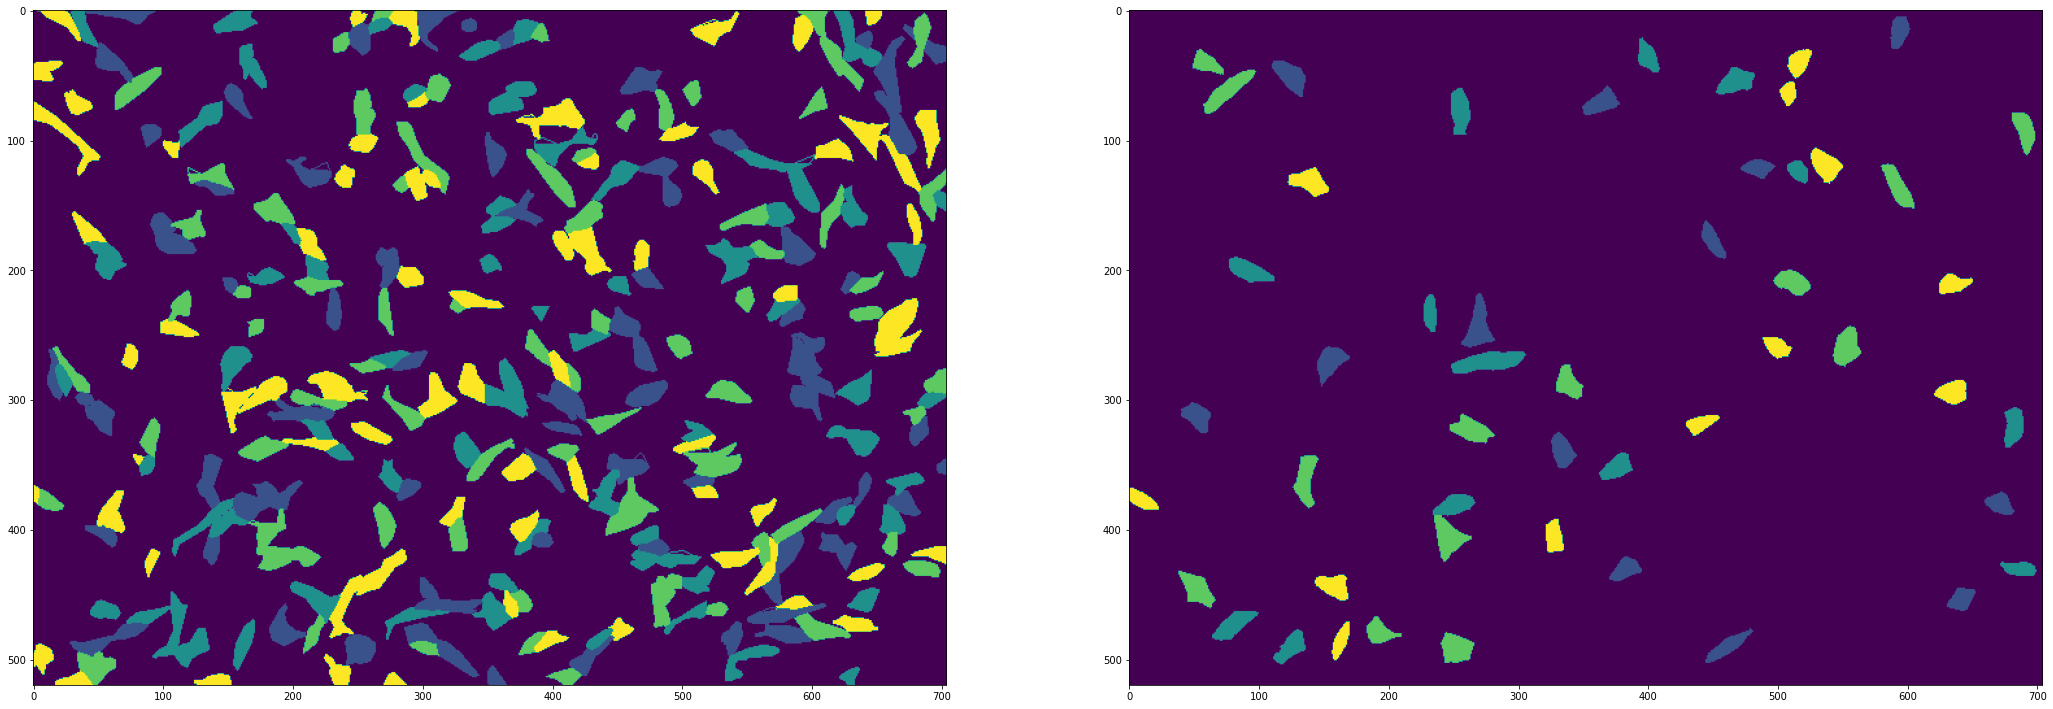

04cd81dfb245


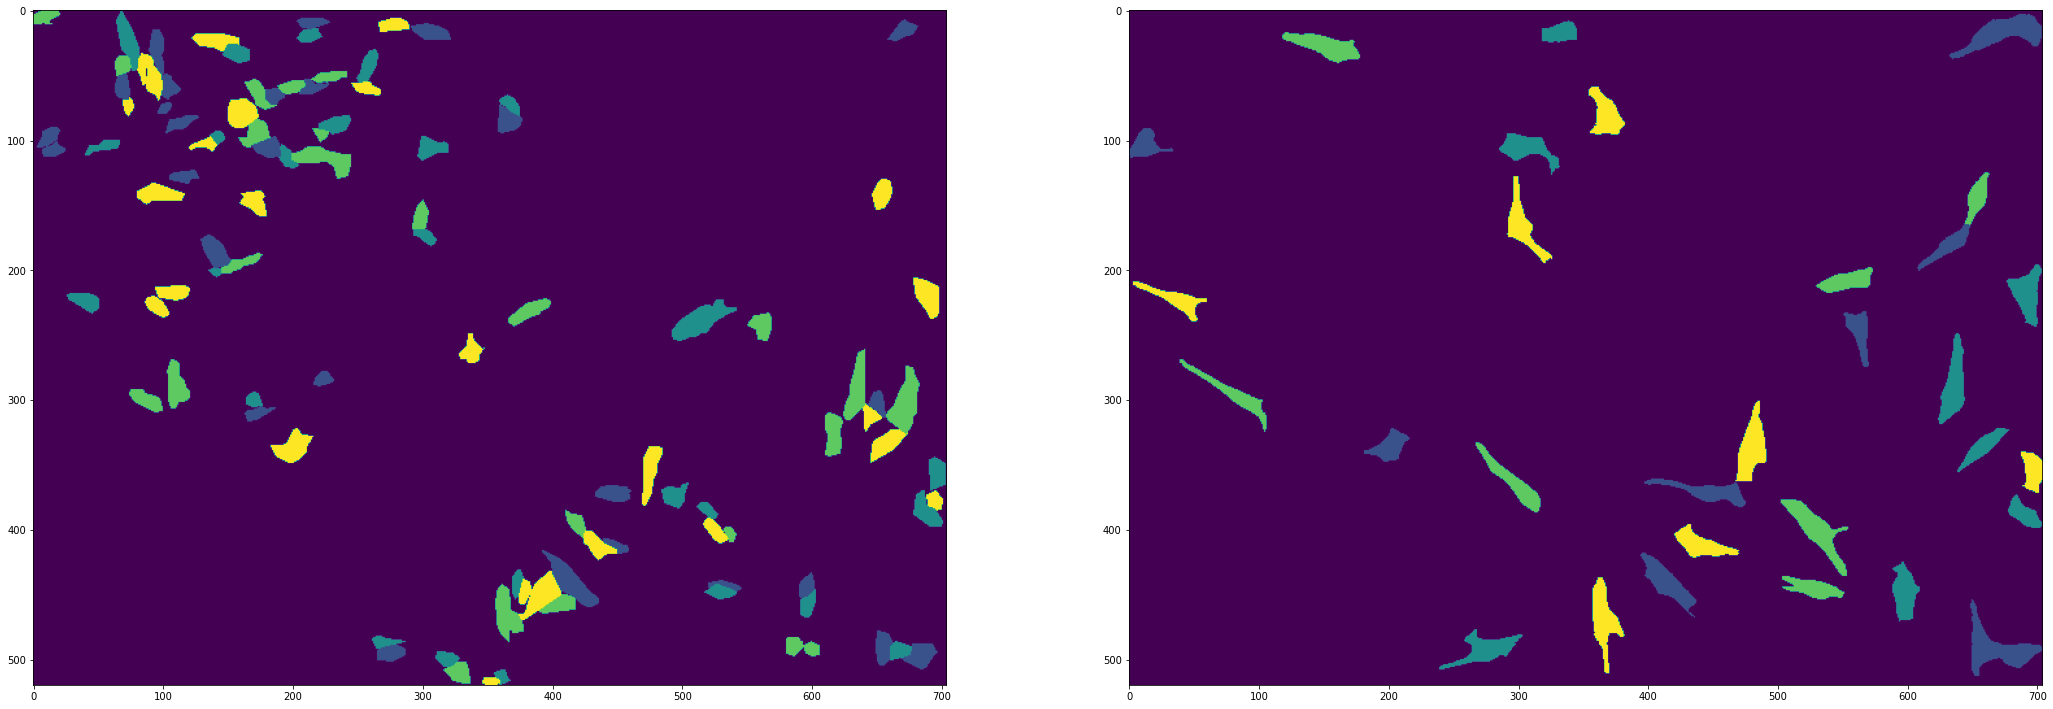

085eb8fec206


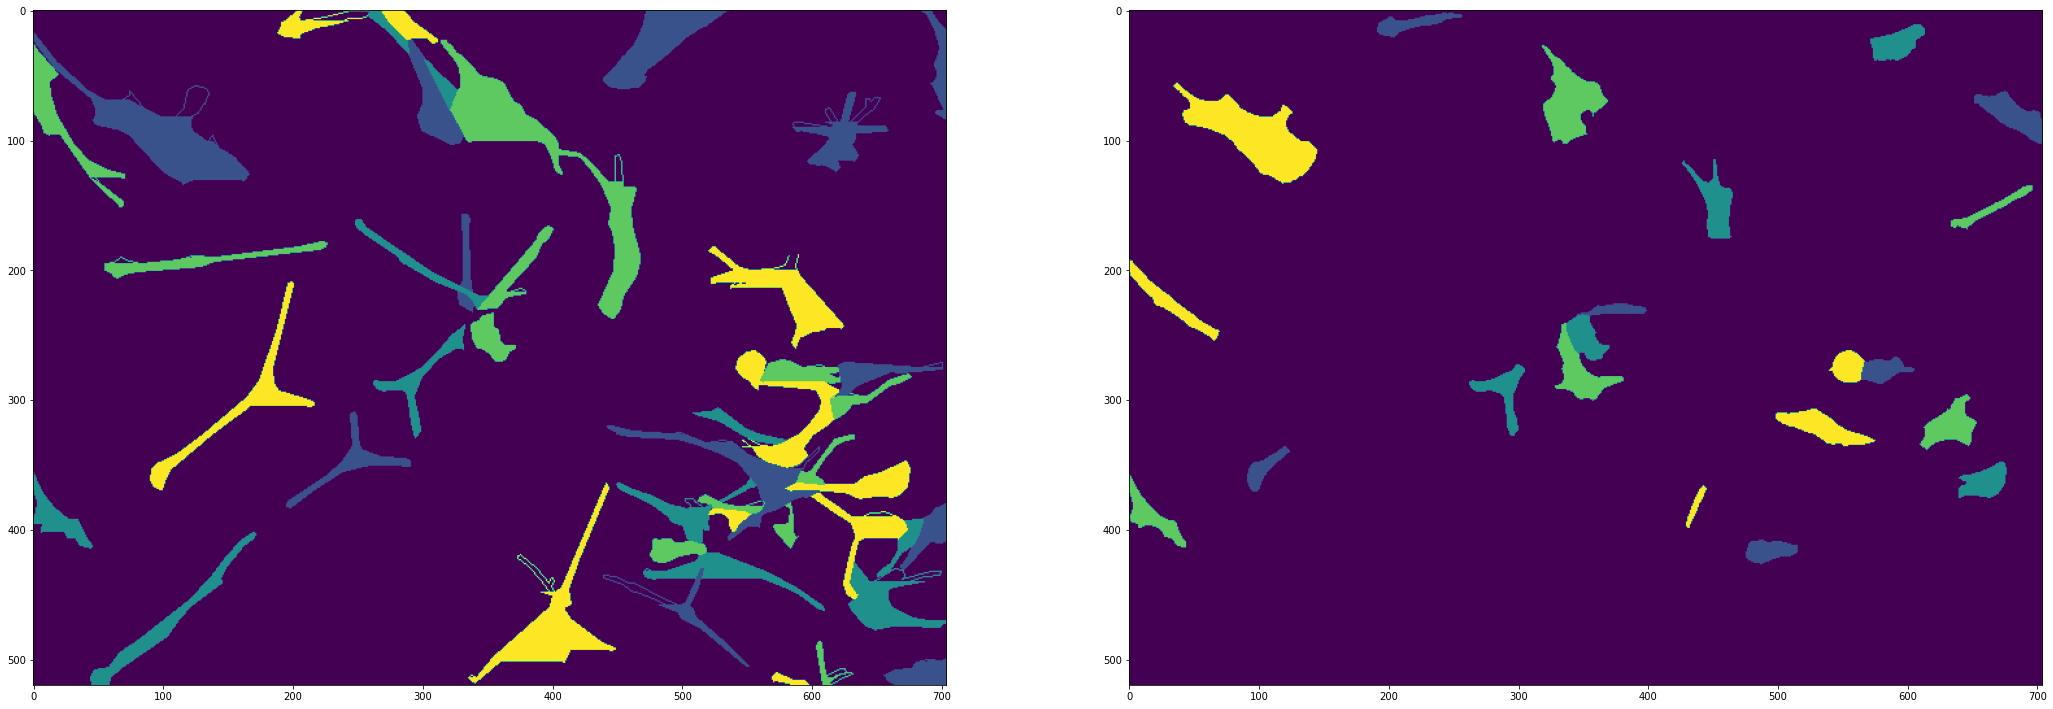

0c90b86742b2


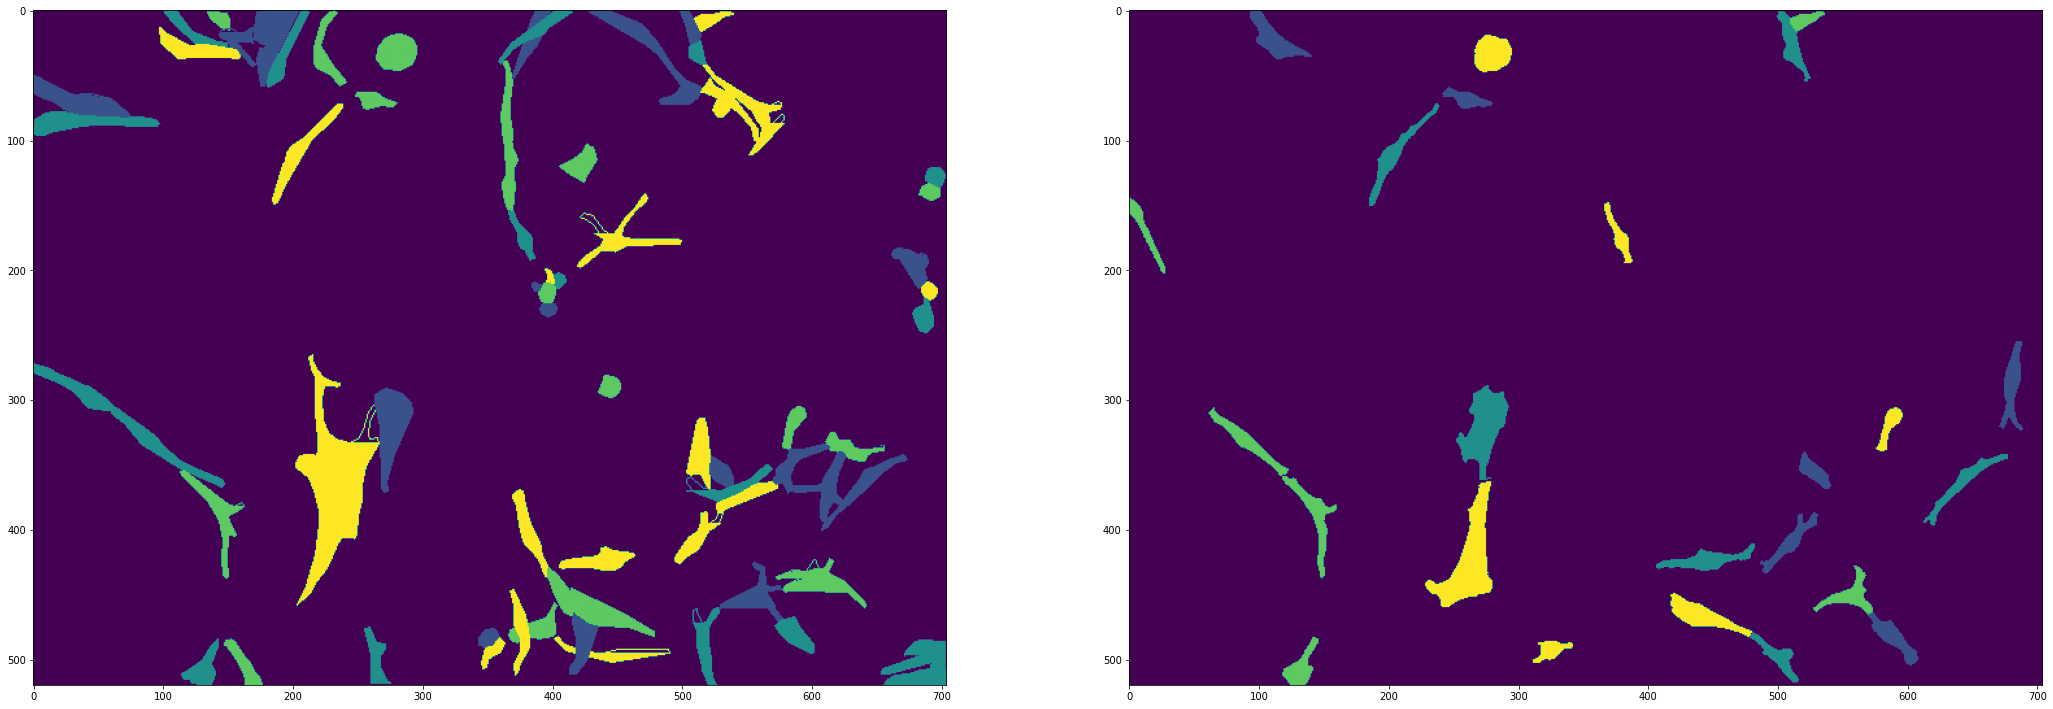

0cfdeeb0dded


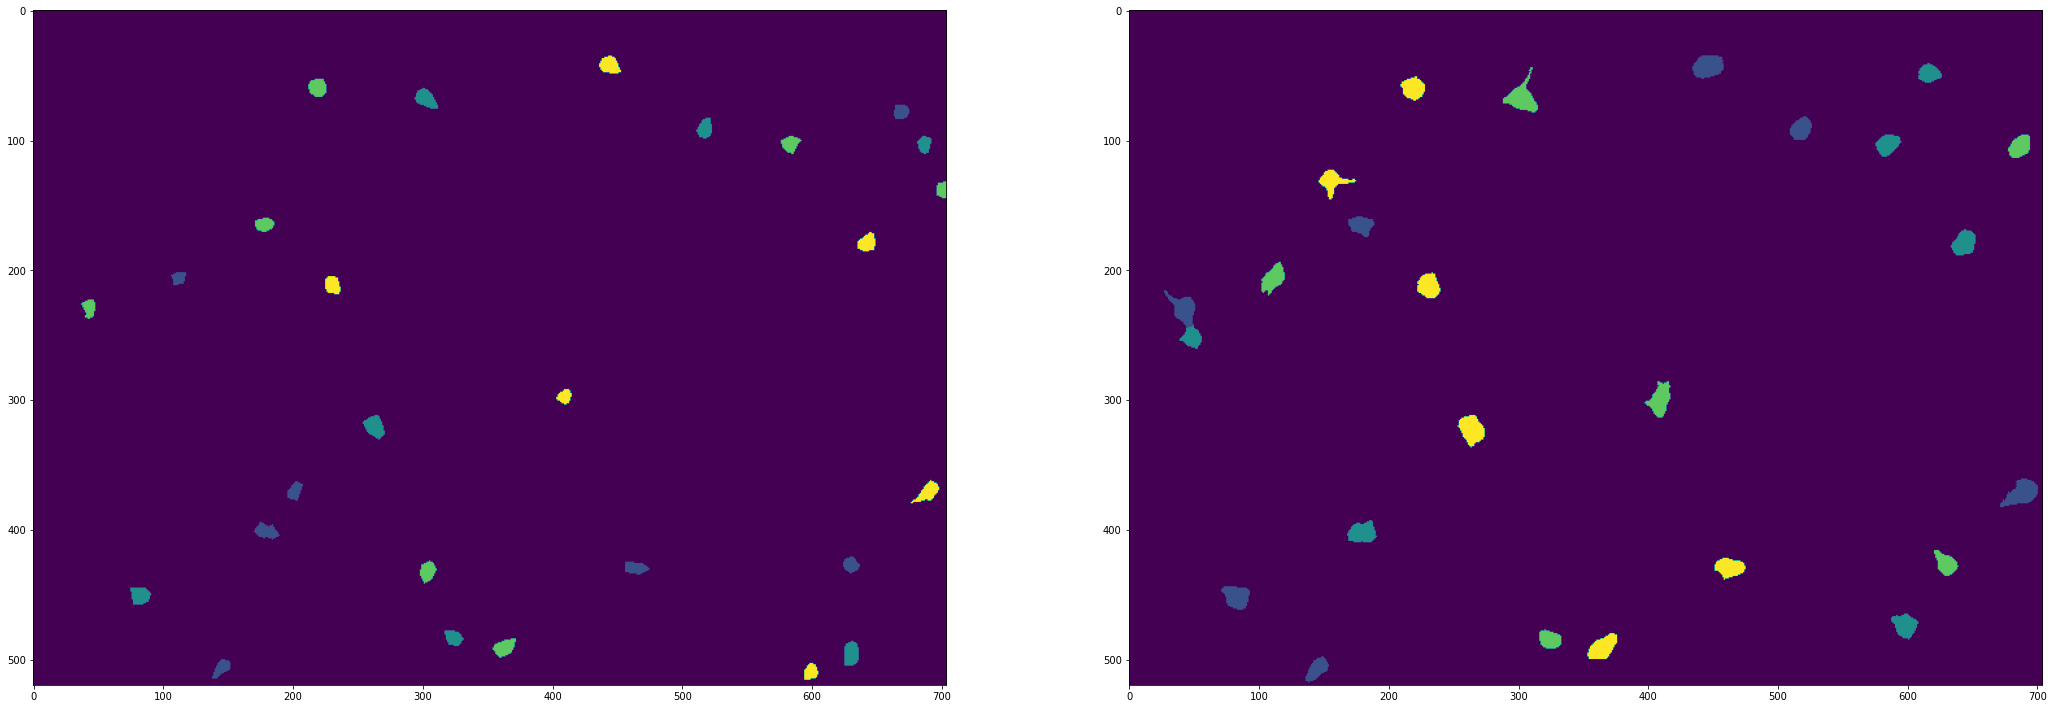

In [35]:
for i,row in df.iterrows():
    
    print(row.id)
    gt_masks = rles_to_mask(row.annotation, shape).astype(np.uint16)
    predicted_masks = rles_to_mask(row.predicted, shape).astype(np.uint16)
    
    gt_masks = (gt_masks>0).astype(int)*(gt_masks%5)
    predicted_masks = (predicted_masks>0).astype(int)*(predicted_masks%5)

    _, axs = plt.subplots(1, 2, figsize=(36, 18))
    axs = axs.flatten()
    axs[0].imshow(gt_masks)
    axs[1].imshow(predicted_masks)
    plt.show()
    
    if i==4: break

## Evaluate

In [36]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrecision\tRecall")

    prec = []
    recalls = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        r = tps / (tps + fns)
        prec.append(p)
        recalls.append(r)
   
        if verbose:
            print("{:1.2f}\t{}\t{}\t{}\t{:1.3f}\t{:1.3f}".format(t, tps, fps, fns, p, r))

    if verbose:
        print("AP\t-\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return round(np.mean(prec),4)

In [37]:
annotations = df.annotation.values
predictions = df.predicted.values

In [38]:
iou_map(annotations,predictions,verbose=1)

0it [00:00, ?it/s]

<ipython-input-33-f92e87a23207>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


(395, 63)
Thresh	TP	FP	FN	Precision	Recall
0.50	3103	849	11599	0.200	0.211
0.55	2900	1052	11802	0.184	0.197
0.60	2602	1350	12100	0.162	0.177
0.65	2227	1725	12475	0.136	0.151
0.70	1730	2222	12972	0.102	0.118
0.75	1188	2764	13514	0.068	0.081
0.80	676	3276	14026	0.038	0.046
0.85	213	3739	14489	0.012	0.014
0.90	23	3929	14679	0.001	0.002
0.95	0	3952	14702	0.000	0.000
AP	-	-	-	-	0.090


0.0902

## Tracking perf. 
### fold-2  
epochs=10, BS=8
iou=0.3543  
Epoch 9, Time 85.6s, Loss 0.5771, Loss Test 0.5457, LR 0.000  
----
epochs=50, BS=8
iou=0.3818  
Epoch 40, Time 313.2s, Loss 0.4704, Loss Test 0.4716, LR 0.0002
##### Increasing epochs 10-->50, increases IoU by 7.7%
##### Reducing BS from 8--->4 doesn't make any difference
